# Team Spending & Regular Season Wins in the NBA
> Exploring the relationship between historical team payrolls and regular season wins.

## Overarching question: Do teams with higher payrolls win more?


### Simplifying Assumptions:
- Looking at a 20 year period, from 1997-98 season through 2017-18 season
- Team payroll is defined as the the sum of all of the team's players' salaries 
- All dollar values are converted to and represented in 2022 USD
- Teams are represented by the names they by which they were known in the given season
- Seasons with lockouts and other special cases will be treated as normal seasons

In [1]:
# Import necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
from scipy import stats

### Datasets

- Salaries.csv ➔ Salary information for every active player by season (obtained from data.world)
- Salary-Cap.csv ➔ NBA salary cap by season (obtained from basketball-reference)
- Inflation.csv ➔ Yearly inflation rates (from Investopedia)
- Team-Records.csv ➔ Team records and win percentages by season (obtained from Kaggle)

In [2]:
# Load in the datasets 
salaries = pd.read_csv("/Users/laurenmanis/Desktop/NBA-Data/salaries.csv")
salary_cap = pd.read_csv("/Users/laurenmanis/Desktop/NBA-Data/salary-cap.csv")
inflation = pd.read_csv("/Users/laurenmanis/Desktop/NBA-Data/inflation.csv")
records = pd.read_csv("/Users/laurenmanis/Desktop/NBA-Data/team-records.csv")

## Data Cleaning & Preparation

In [3]:
################ Salary Cap Dataset ################
# Re-format column names 
salary_cap.rename(columns={
    "Season": "season",
    "Salary Cap": "salary_cap",
    "2022 Dollars": "salary_cap_2022_usd",
}, inplace=True)

salary_cap.head()

,season,salary_cap,salary_cap_2022_usd
0,1984-85,3600000,9793069.0
1,1985-86,4233000,11298280.0
2,1986-87,4945000,12734751.0
3,1987-88,6164000,15248702.0
4,1988-89,7232000,17069461.0


In [4]:
################ Inflation Dataset ################
inflation.head()

,year,inflation_rate
0,1980,0.125
1,1981,0.089
2,1982,0.038
3,1983,0.038
4,1984,0.039


In [5]:
################ Team Records Dataset ################
# Re-format column names 
records.rename(columns={
    "Year": "season",
}, inplace=True)

# Convert remaining column names to colower case 
records.columns = [col.lower() for col in records.columns]

# Create new columns for wins and losses 
records['wins'] = records['record'].str.split('-').str[0]
records['losses'] = records['record'].str.split('-').str[1]

# Explicity rename seasons with asterisks (lockout/strike seasons)
records['season'] = records['season'].replace('2011-12 *', '2011-12')
records['season'] = records['season'].replace('1998-99 *', '1998-99')

# Drop rows outside of the specified time frame 
records = records[records['season'] >= '1997-1998']

records.sample(n=5)

,season,team,record,win%,wins,losses
964,2007-08,Raptors,41-41,0.500,41,41
44,2011-12,Celtics,39-27,0.591,39,27
130,1999-00,Hornets,49-33,0.598,49,33
958,2013-14,Raptors,48-34,0.585,48,34
540,1999-00,Grizzlies,22-60,0.268,22,60


In [6]:
################ Salaries Dataset ################
# Adjust team column to show each team name as one word, excluding the city 
salaries['team'] = salaries['team'].str.split(" ").str[-1]

# Rename "Blazers" to "Trail Blazers" to match records dataset
salaries['team'] = salaries['team'].replace('Blazers', 'Trail Blazers')

# Drop rows outside of the specified time frame 
salaries = salaries[(salaries['season'] >= '1997-1998') & (salaries['season'] <= '2017-2018')]

salaries.sample(n=5)

,league,player_id,salary,season,season_end,season_start,team
6142,NBA,iveyro01,1050000,2009-10,2010,2009,Bucks
12437,NBA,thomptr02,762195,2012-13,2013,2012,Clippers
9757,NBA,parisro01,1150000,1997-98,1998,1997,Bulls
5113,NBA,hamilri01,1836240,1999-00,2000,1999,Wizards
10078,NBA,piercpa01,2051271,2001-02,2002,2001,Celtics


In [7]:
# Convert all salary values to 2022 USD, using the inflation dataset
inflation.set_index('year', inplace=True)

def inflation_adjust(year, salary):
    year = int(year)  
    cumulative_inflation = 1 

    for yr in range(year, 2022):
        annual_inflation = inflation.at[yr, 'inflation_rate'] + 1
        cumulative_inflation *= annual_inflation
        
    adjusted_salary = salary * cumulative_inflation 
    return adjusted_salary

# Add column for estimated salary in 2022 USD
salaries['salary_adj'] = salaries.apply(lambda row: inflation_adjust(row['season_start'], row['salary']),axis=1)

salaries.sample(n=5)

,league,player_id,salary,season,season_end,season_start,team,salary_adj
6618,NBA,johnske02,8000000,1997-98,1998,1997,Suns,1.408208e+07
4933,NBA,greener01,99418,2015-16,2016,2015,Jazz,1.180368e+05
6744,NBA,jonesdo02,1110120,2010-11,2011,2010,Mavericks,1.433749e+06
9373,NBA,ntilila01,3501120,2017-18,2018,2017,Knicks,4.043005e+06
13813,NBA,willisc01,4200000,2000-01,2001,2000,Bucks,6.966922e+06


In [8]:
################ Final DataFrame Compilation ################

# Compute team payrolls by season and create a new dataframe 
payrolls = salaries.groupby(['season', 'team'])['salary_adj'].sum().reset_index()

# Add a column for season salary cap
cap = salary_cap[['season', 'salary_cap_2022_usd']]
payrolls = payrolls.merge(cap, how='left', on='season')

# Add team record information to the dataframe
df = payrolls.merge(records, how='left', on=['season','team'])

# Add a column showing remaining cap space for each team
df['cap_space'] = df['salary_cap_2022_usd'] - df['salary_adj']

# Add a column to indicate if a team is cap compliant
def cap_compliant(cap_space):
    if cap_space > 0:
        return "Yes"
    else:
        return "No"
    
df['cap_compliant'] = df['cap_space'].apply(cap_compliant)

# Rename columns for improved clarity and readability 
df.rename(columns={
    "salary_adj": "payroll",
    "salary_cap_2022_usd": "salary_cap"
}, inplace=True)

# Add a column to classify teams into buckets based on salary cap space 
def cap_space_bucket(cap_space):
    if cap_space >= 0:
        return 'A. Below Cap'
    elif (cap_space < 0) & (cap_space >= -15000000):
        return 'B. $1-$10M Over Cap'
    elif (cap_space < -15000000) & (cap_space >= -25000000):
        return 'C. $10-$20M Over Cap'
    else:
        return 'D. >$25 M Over Cap'
    
df['cap_bucket'] = df['cap_space'].apply(cap_space_bucket)

# Drop rows with no record data (rows for Seattle SuperSonics who no longer exist)
df = df[df['record'].notna()]

# Create columns for payroll and salary cap in $M, to be used for visualizations
df['salary_cap_m'] = df['salary_cap'] / 1000000
df['payroll_m'] = df['payroll'] / 1000000

df.sample(n=5)

,season,team,payroll,salary_cap,record,win%,wins,losses,cap_space,cap_compliant,cap_bucket,salary_cap_m,payroll_m
275,2006-07,Kings,9.108996e+07,74973988.0,33-49,0.402,33,49,-1.611597e+07,No,C. $10-$20M Over Cap,74.973988,91.089957
0,1997-98,76ers,5.037955e+07,48285994.0,31-51,0.378,31,51,-2.093556e+06,No,B. $1-$10M Over Cap,48.285994,50.379550
338,2008-09,Magic,9.250649e+07,80023973.0,59-23,0.720,59,23,-1.248252e+07,No,B. $1-$10M Over Cap,80.023973,92.506490
583,2016-17,Pistons,1.274100e+08,112368348.0,37-45,0.451,37,45,-1.504165e+07,No,C. $10-$20M Over Cap,112.368348,127.409997
224,2004-05,Raptors,9.337165e+07,65719039.0,33-49,0.402,33,49,-2.765261e+07,No,D. >$25 M Over Cap,65.719039,93.371645


## Exploratory Data Analysis & Descriptive Statistics 

In [9]:
# Average team payroll by season
avg_payroll = df.groupby('season')['payroll'].mean().reset_index()
avg_payroll['payroll'].mean()

89170851.84560862

In [10]:
# Salary Cap Compliance by season
cap_compliant_teams = df[df['cap_compliant'] == "Yes"].groupby('season')['cap_compliant'].count().reset_index()
cap_compliant_teams['cap_compliant'].mean()

5.4

## Visualizations

(1) How has team spending varied with salary cap changes?

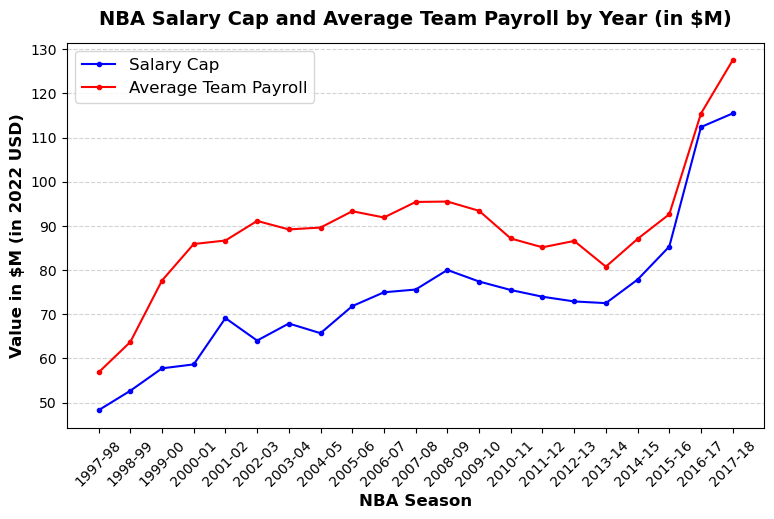

In [11]:
# Subset the df
data = pd.DataFrame(df.groupby(['season','salary_cap_m'])['payroll_m'].mean()).reset_index()

# Create a line plot with one line showing salary cap growth and the other showing mean team payroll growth
plt.figure(figsize=(9,5))
plt.plot(data['season'], data['salary_cap_m'], label='Salary Cap', color='blue', marker='.')
plt.plot(data['season'], data['payroll_m'], label='Average Team Payroll', color='red', marker='.')
plt.grid(color='lightgrey', linestyle='--', axis='y')
plt.title("NBA Salary Cap and Average Team Payroll by Year (in $M)", fontweight='bold', fontsize=14, y=1.025)
plt.xlabel("NBA Season", fontsize=12, fontweight='bold')
plt.ylabel("Value in $M (in 2022 USD)", fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(labels=['Salary Cap', 'Average Team Payroll'], fontsize=12);

Changes in average team payroll follow the same general trend as changes in the salary cap, however, the average team payroll is consistently larger than the salary cap for any given season.

These values start to converge more in the later years, as a result of a large jump in the salary cap, put in place for the 2016-17 season.

(2) What is the relationship between team payroll and number of games won?

correlation coefficient = 0.31
p-value = 9e-15


True

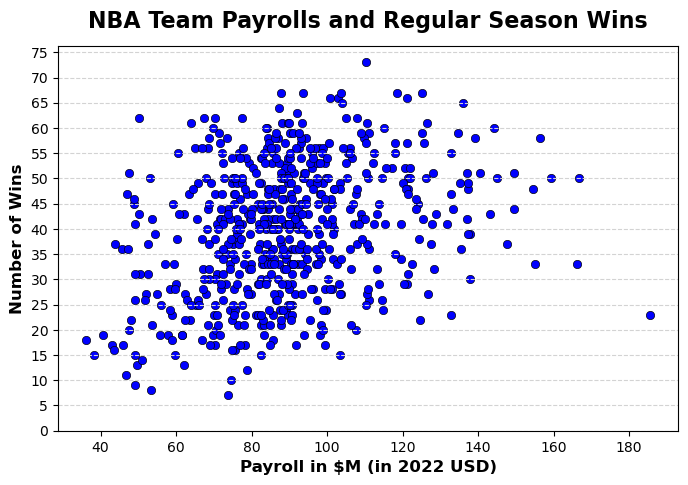

In [12]:
# Convert wins column to type int
df['wins'] = pd.to_numeric(df['wins'], errors='coerce')

# Create a scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='payroll_m', y='wins', edgecolor='black', color='blue')
plt.yticks(np.arange(0, 80, 5))
plt.grid(color='lightgrey', linestyle='--', axis='y')
plt.title("NBA Team Payrolls and Regular Season Wins", fontweight='bold', fontsize=16, y=1.025)
plt.xlabel("Payroll in $M (in 2022 USD)", fontsize=12, fontweight='bold')
plt.ylabel("Number of Wins", fontsize=12, fontweight='bold');

corr = stats.pearsonr(df['payroll_m'], df['wins'])
print("correlation coefficient =", corr[0].round(decimals=2))
print("p-value =", corr[1].round(decimals=15))
corr[1] < 0.05

There appears to be some positive relationship between team payroll and number of regular season wins.
In general, as a team’s payroll increases, so does their number of wins, though this relationship is weak.

Correlation Coefficient = 0.31

P-Value = 9e-15, Statistically significant at the 0.05 level

(3) Games won by salary cap bucket 

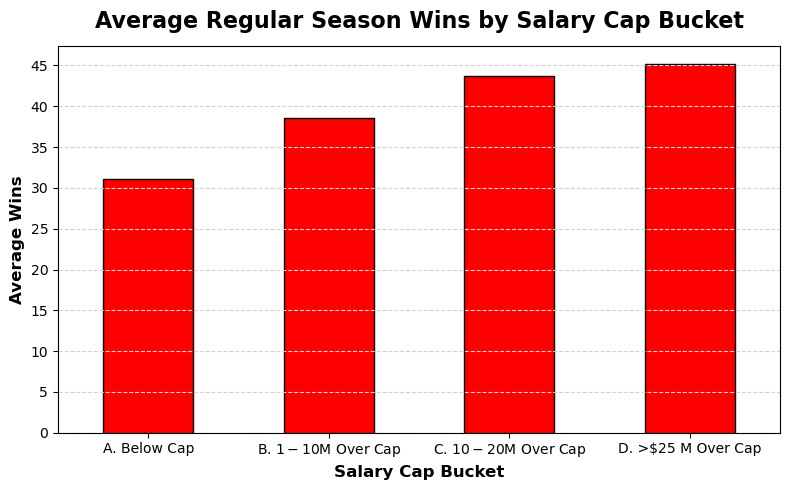

In [13]:
# Subset the data
data3 = df.groupby('cap_bucket')['wins'].mean()

# Create a bar plot
plt.figure(figsize=(8,5))
data3.plot(kind='bar', color='red', edgecolor='black')
plt.title('Average Regular Season Wins by Salary Cap Bucket', fontweight='bold', fontsize=16, y=1.025)
plt.xlabel('Salary Cap Bucket', fontsize=12, fontweight='bold')
plt.ylabel('Average Wins',fontsize=12, fontweight='bold')
plt.grid(color='lightgrey', linestyle='--', axis='y')
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 50, 5))
plt.tight_layout()

When team payrolls are grouped into buckets based on their cap space, there is a clear upward trend, where teams with higher payrolls relative to the cap win more games. 
In other words, as the gap between a team’s payroll and the salary cap grows, so does their number of wins. 

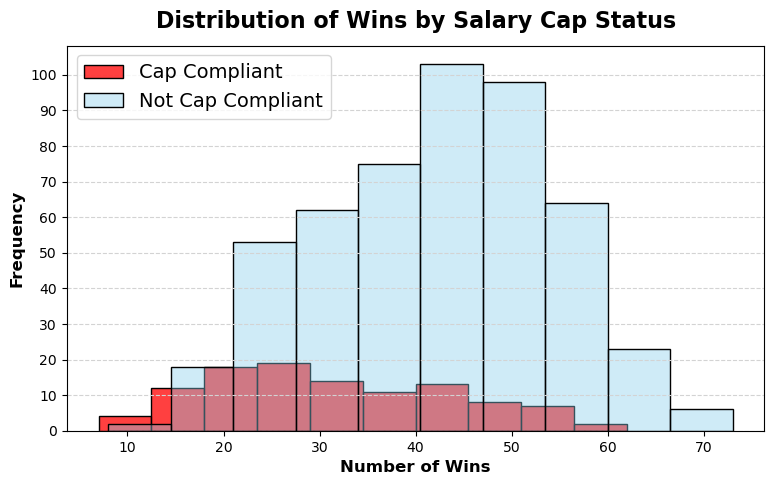

In [14]:
# Seaparate cap compliant vs non-cap compliant observations 
below_cap = df[df['cap_compliant'] == 'Yes']
above_cap = df[df['cap_compliant'] == 'No']

# Create histograms showing distribution of wins
plt.figure(figsize=(9,5))
sns.histplot(below_cap['wins'], color='red', edgecolor='black', bins=10)
sns.histplot(above_cap['wins'], color='skyblue', edgecolor='black', bins=10, alpha=0.4)
plt.grid(color='lightgrey', linestyle='--', axis='y')
plt.title('Distribution of Wins by Salary Cap Status', fontweight='bold', fontsize=16, y=1.025)
plt.legend(labels=['Cap Compliant', 'Not Cap Compliant'], fontsize=14)
plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Number of Wins', fontsize=12, fontweight='bold');

Teams who are not cap compliant (above the salary cap), win larger numbers of games more frequently.
For cap-compliant teams, the most frequent number of games won is around 25, whereas for non-compliant teams, it is around 45.
Moreover, no cap-compliant team has ever reached the 70-win threshold. 

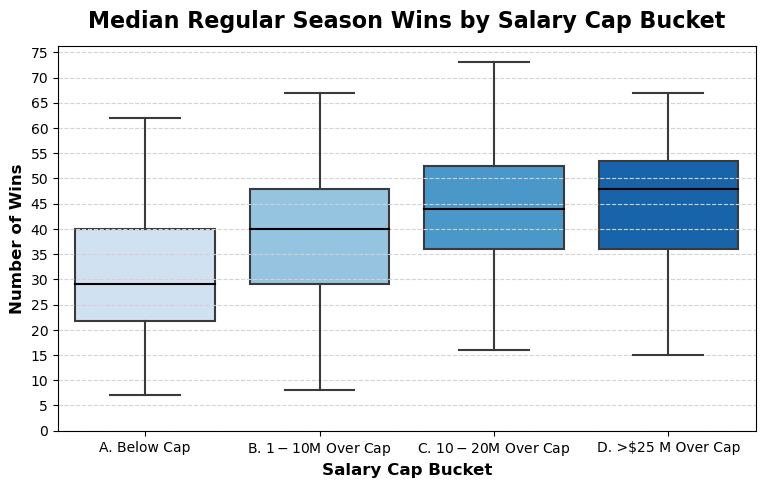

In [15]:
# Create a box plot showing median wins by salary cap bucket
sorted_order = sorted(df['cap_bucket'].unique())

plt.figure(figsize=(9,5))
plt.grid(color='lightgrey', linestyle='--', axis='y')
sns.boxplot(x='cap_bucket', y='wins', data=df, order=sorted_order, palette='Blues', saturation=1, medianprops={"color": "black"})
plt.title('Median Regular Season Wins by Salary Cap Bucket', fontweight='bold', fontsize=16, y=1.025)
plt.xlabel('Salary Cap Bucket', fontsize=12, fontweight='bold')
plt.ylabel('Number of Wins', fontsize=12, fontweight='bold')
plt.yticks(np.arange(0, 80, 5))
plt.show()

Similarly with average regular season wins, as teams go further above the salary cap, their median wins increase.
However, the range of wins for teams in bucket C, $10-$20M above the cap, skews the highest.

(4) Most vs Least Wins in a season

In [16]:
wins_df = df.sort_values(by='wins', ascending=False)
wins_df = wins_df[['season','team','payroll_m','record','wins','win%','cap_bucket']].head(n=10)
wins_df.rename(columns={
    "season": "Season",
    "team": "Team",
    "payroll_m": "Payroll ($M)",
    "record": "Record",
    "wins": "Wins",
    "win%": "Win %",
    "cap_bucket": "Salary Cap Bucket"
}, inplace=True)

wins_df['Payroll ($M)'] = wins_df['Payroll ($M)'].round(decimals=2)
wins_df['Win %'] = (wins_df['Win %'] * 100).round(decimals=2)
wins_df.reset_index(drop=True, inplace=True)
wins_df

,Season,Team,Payroll ($M),Record,Wins,Win %,Salary Cap Bucket
0,2015-16,Warriors,110.25,73-9,73,89.0,C. $10-$20M Over Cap
1,1999-00,Lakers,93.73,67-15,67,81.7,D. >$25 M Over Cap
2,2006-07,Mavericks,125.27,67-15,67,81.7,D. >$25 M Over Cap
3,2015-16,Spurs,103.73,67-15,67,81.7,C. $10-$20M Over Cap
4,2016-17,Warriors,118.48,67-15,67,81.7,B. $1-$10M Over Cap
5,2014-15,Warriors,87.83,67-15,67,81.7,B. $1-$10M Over Cap
6,2007-08,Celtics,102.80,66-16,66,80.5,D. >$25 M Over Cap
7,2012-13,Heat,100.76,66-16,66,80.5,D. >$25 M Over Cap
8,2008-09,Cavaliers,121.22,66-16,66,80.5,D. >$25 M Over Cap
9,2008-09,Lakers,103.89,65-17,65,79.3,C. $10-$20M Over Cap


Every one of the top 10 winningest teams in the dataset were above the salary cap.
8 out of the 10 were at least $10M over the cap.
Additionally, 6 of these teams went on to win the championship in the given year.

## Takeaways & Next Steps
Based on the data, it appears that teams with higher payrolls, specifically those above the salary cap, win more games in the regular season, on average.

If this is indeed the case, teams hoping to make a championship run are justified in their action of spending more money on personnel and going above the salary cap.

More research and further analysis would be needed to confirm this hypothesis, including:
Additional consideration for cap exceptions 
- Other factors in wins (coaching, home court advantage, schedule, etc.)
- Injuries
- 2-way player consideration
- Etc.
 
